This code reads the SLUG models from Krumholz et al. 2015, and it reads the tottal ionizing flux Qo, mass, age, and Av of the clusters in the library
It makes a mapping between cluster mass and H-alpha luminosity (via Qo) and it integrates the cluster mass function above a limiting mass corresponding
to the minimum HII region luminosity in Santoro et al. 2022.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits

In [45]:
# Read SLUG models

phot=fits.open('../slug/modp020_chabrier_MW_cluster_phot.fits')
prop=fits.open('../slug/modp020_chabrier_MW_cluster_prop.fits')

#phot=fits.open('../slug/kafc18/kafc18_cluster_phot.fits')
#prop=fits.open('../slug/kafc18/kafc18_cluster_prop.fits')

print(len(phot))

238


In [46]:
phot[2].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    8 / length of dimension 1                          
NAXIS2  =             10000000 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    1 / number of table fields                         
TTYPE1  = 'QH0     '                                                            
TFORM1  = '1D      '                                                            
TUNIT1  = 'phot/s  '                                                            

In [47]:
#for i in range(len(phot)):
#    if i!=0:
#        print(i, phot[i].data.columns)

In [48]:
prop[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   88 / length of dimension 1                          
NAXIS2  =             10000000 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   11 / number of table fields                         
TTYPE1  = 'Trial   '                                                            
TFORM1  = '1K      '                                                            
TTYPE2  = 'UniqueID'                                                            
TFORM2  = '1K      '                                                            
TTYPE3  = 'Time    '        

In [53]:
age=prop[1].data['Time']
mass=prop[1].data['LiveMass']
av=prop[1].data['A_V']
q0=np.array(phot[2].data).astype(float)
fesc=0.5
lha=(1.37e-12)*q0*fesc

# NGC 1566 from Santoro et al. 2021
lcom=36.77
lmin=37.14
lmax=40.53
# NGC 1566 median GMC mass and LHa from catalog
mgmc=3.56e6
lmed=37.46

sel0=(age>1e6)*(age<9e6)*(av<2)
sel=(age>1e6)*(age<9e6)*(av<2)*(np.log10(lha)>lcom)*(np.log10(lha)<lmax)

dmbin=0.1
mbins=np.arange(2, 6, dmbin)+dmbin/2
lhabins=np.zeros_like(mbins)

for i in range(len(mbins)):
    binsel=(np.log10(mass[sel0])>mbins[i]-dmbin/2)*(np.log10(mass[sel0])<mbins[i]+dmbin/2)
    lhabins[i]=np.log10(np.median(lha[sel0][binsel]))
    
print(mbins, lhabins)


medmc=np.median(mass[sel])
#medmc=3.3e3
sfe=0.1
Ntot=mgmc*sfe/medmc

print(Ntot)


# This is wrong. I need to integrate a cluster mass function above a certain limit! 
# A lot of the stellar mass (mgmc*sfe) forms into low mass clusters with no ionizing stars.



/Users/gblancm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/Users/gblancm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


[2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75 2.85 2.95 3.05 3.15 3.25 3.35
 3.45 3.55 3.65 3.75 3.85 3.95 4.05 4.15 4.25 4.35 4.45 4.55 4.65 4.75
 4.85 4.95 5.05 5.15 5.25 5.35 5.45 5.55 5.65 5.75 5.85 5.95] [34.00218969 34.54399362 34.96806202 35.29971293 35.63227256 35.91941586
 36.14621578 36.32210464 36.51029704 36.69283633 36.85579186 37.01423651
 37.16749585 37.31366596 37.44955126 37.58779057 37.72377635 37.85284407
 37.99205093 38.13096847 38.28143219 38.40497472 38.52019165 38.63099652
 38.74826593 38.86578529 38.97762255 39.07556564 39.18700634 39.32165813
 39.41391107 39.51143192 39.62304496 39.71371339 39.7939952  39.91455979
 40.02759794 40.13625079 40.14610223 40.3013684 ]
78.9276223022349


In [57]:
mcmax=1e7
mcmin=1e2
mclim=1e3

A=mgmc*sfe/np.log(mcmax/mcmin)
Ntot=A*(1/mclim-1/mcmax)
print('Nc,prior = ', Ntot)


Nc,prior =  30.91867493480038


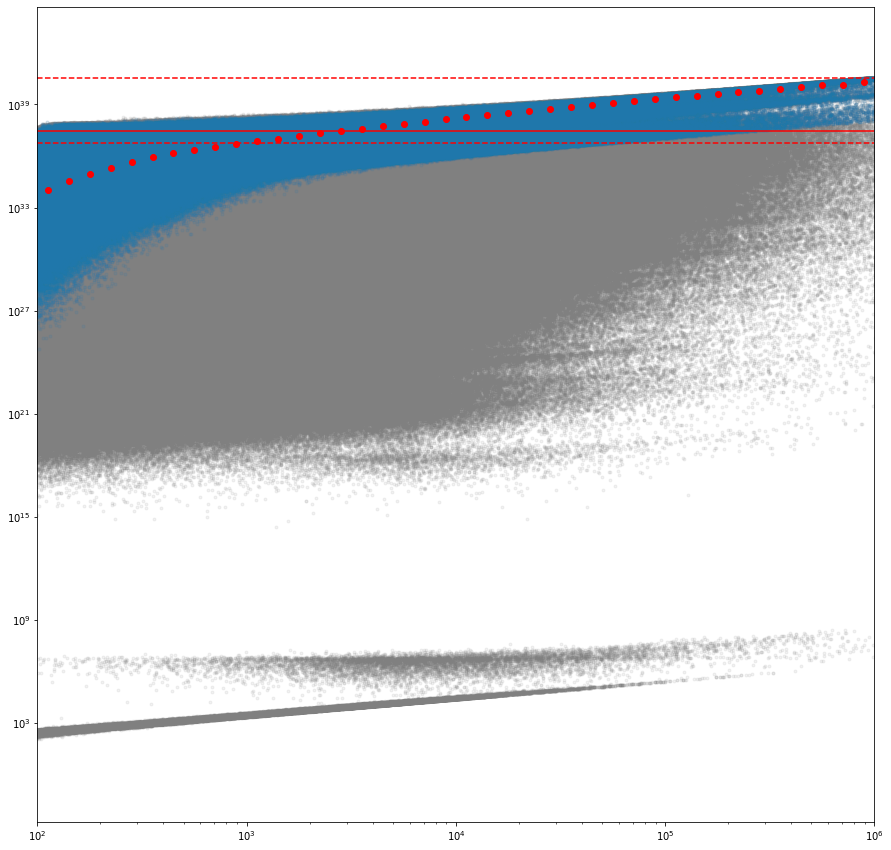

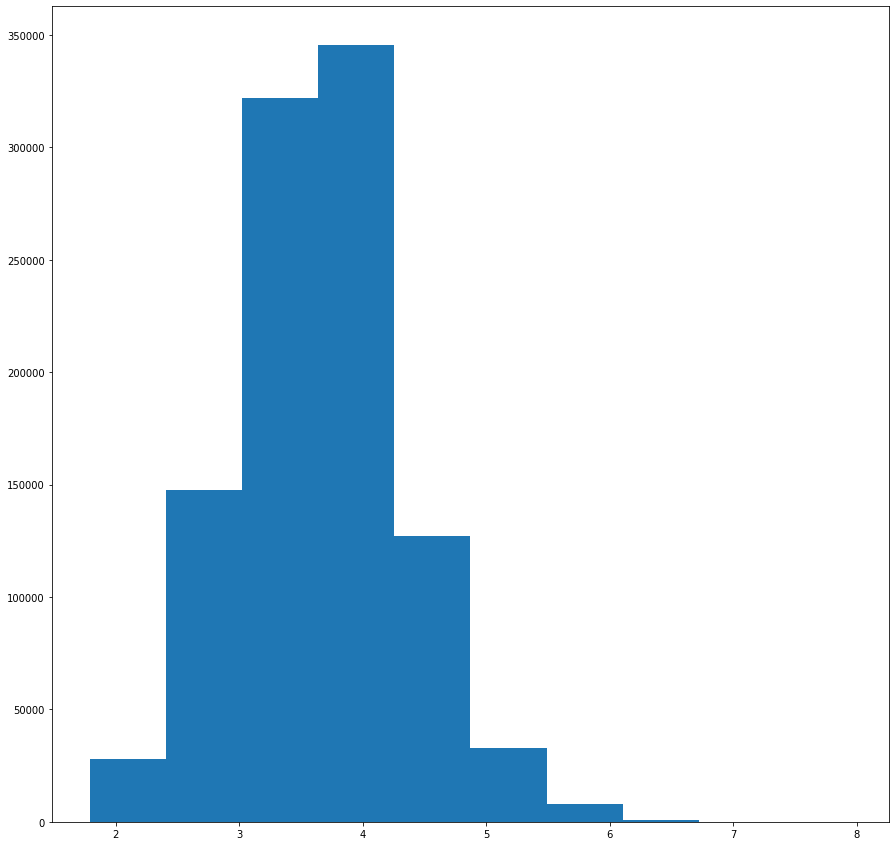

In [55]:


fig1,ax1=plt.subplots(figsize=(15, 15))
ax1.plot(mass, lha, '.', alpha=0.1, color='grey')
ax1.plot(mass[sel0], lha[sel0], '.', alpha=0.1)
ax1.plot(10**mbins, 10**lhabins, 'o', color='red')
#ax1.plot(mass[sel], lha[sel], '.', alpha=0.1, color='red')
ax1.axhline(10**lcom, linestyle='--', color='red')
ax1.axhline(10**lmax, linestyle='--', color='red')
ax1.axhline(10**lmed, color='red')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e2, 1e6)
plt.show()

fig2,ax2=plt.subplots(figsize=(15, 15))
ax2.hist(np.log10(mass[sel]))
plt.show()

